In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from tensorflow import keras
import numpy as np
from datasets import load_dataset
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input,GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG19
from keras.optimizers import SGD,Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [23]:
data =load_dataset("razor7x/Interior_Design_Dataset")

Classes: ['A photo of Nordic style interior design', 'A photo of Industrial style interior design', 'A photo of Luxury style interior design', 'A photo of Country style interior design', 'A photo of Modern style interior design', 'A photo of Japanese style interior design']
Degree Centrality: {'A photo of Nordic style interior design': 1.0, 'A photo of Industrial style interior design': 1.0, 'A photo of Luxury style interior design': 1.0, 'A photo of Country style interior design': 1.0, 'A photo of Modern style interior design': 1.0, 'A photo of Japanese style interior design': 1.0}


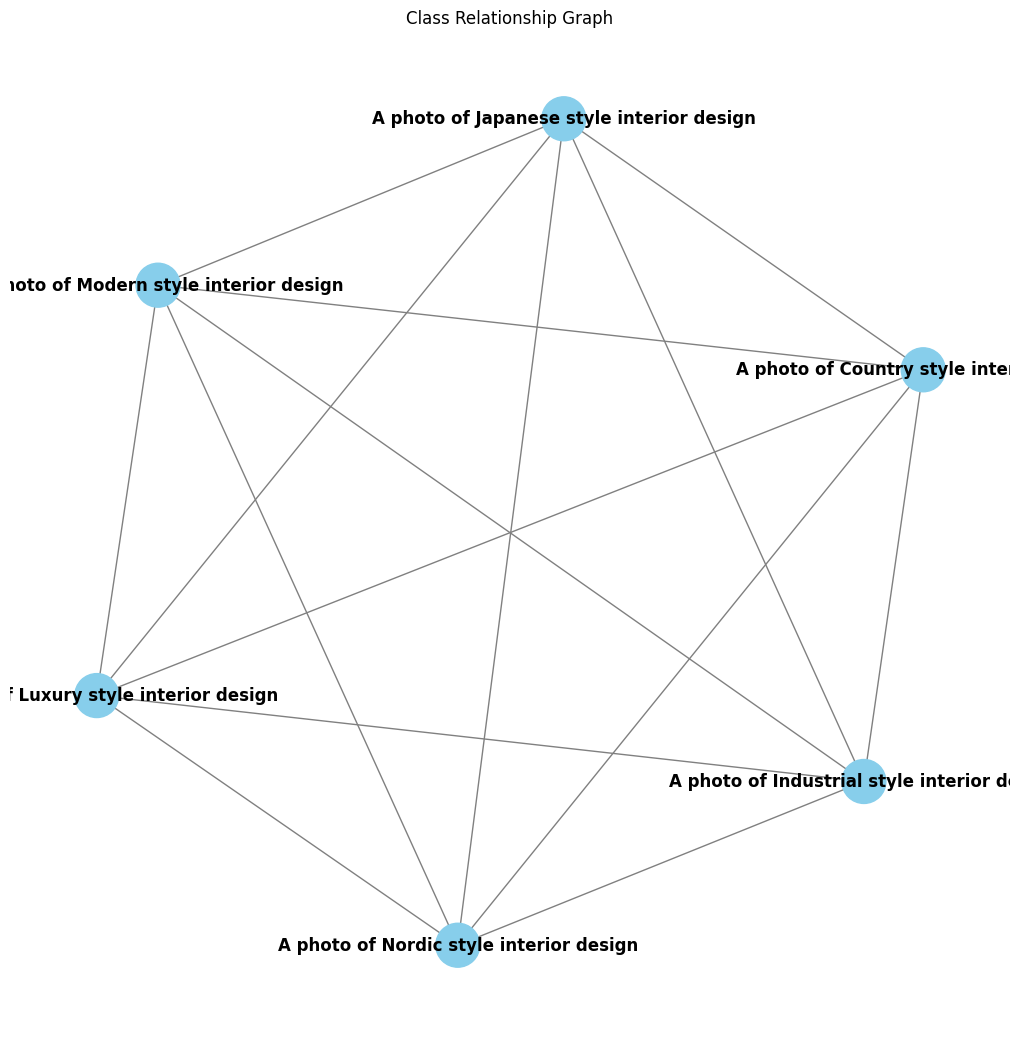

In [36]:
d = data["train"]

# Extract unique classes
classes = list(set([item['text'] for item in d]))
print("Classes:", classes)

# Create a mapping of images to classes
image_classes = {i: d[i]['text'] for i in range(len(d))}

# Create edges: Connect classes that share images
edges = []
for i in range(len(d)):
    for j in range(i + 1, len(d)):
        if image_classes[i] != image_classes[j]:
            edges.append((image_classes[i], image_classes[j]))

# Create a graph
graph = nx.Graph()
graph.add_nodes_from(classes)
graph.add_edges_from(edges)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree Centrality:", degree_centrality)

# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph)  # Layout for graph visualization
nx.draw(
    graph, pos, with_labels=True, node_color='skyblue', edge_color='gray',
    node_size=[1000 * v for v in degree_centrality.values()], font_weight='bold'
)
plt.title("Class Relationship Graph")
plt.show()


In [5]:
def resize_images(example):
    resized_images = []
    for image in example['image']:
        # Convert bytes to PIL.Image if necessary
        if not isinstance(image, Image.Image):
            img = Image.open(io.BytesIO(image))
        else:
            img = image

        img = img.resize((32, 32))
        img_bytes= io.BytesIO()
        img.save(img_bytes, format='JPEG')
        resized_images.append(img_bytes.getvalue())

    example['image'] = resized_images
    return example

# Apply resizing directly on the dataset
data = data.map(resize_images, batched=True)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
print(f"Dataset loaded. Train set: {len(data['train'])} samples")
print(f"Dataset loaded. Train set: {data['train']} samples")



Dataset loaded. Train set: 1000 samples
Dataset loaded. Train set: Dataset({
    features: ['image', 'text'],
    num_rows: 1000
}) samples


In [7]:
label_encoder = LabelEncoder()

# Fit and encode the labels
encoded_labels = label_encoder.fit_transform(data['train']['text'])

# Update the dataset with encoded labels as numpy arrays
def encode_labels(example):
    # Replace the text with its encoded version as a NumPy array
    example['text'] = np.array(label_encoder.transform([example['text']]), dtype=np.int32)
    return example

# Apply the encoding function to the training dataset
data['train'] = data['train'].map(encode_labels)

# Verify the result
print(data['train'][0])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x7E568476E950>, 'text': [4]}


In [8]:
train_test_split = data["train"].train_test_split(test_size=0.2, seed=42)
test_valid_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)
test_valid_split
splits = {
    "train": train_test_split["train"],
    "validation": test_valid_split["train"],
    "test": test_valid_split["test"]
}
train=splits['train']
validation=splits['validation']
test=splits['test']
# Check the resulting splits
print(f"Train size: {len(train)}")
print(f"Validation size: {len(validation)}")
print(f"Test size: {len(test)}")


Train size: 800
Validation size: 100
Test size: 100


In [9]:
X_train = train["image"]
X_val = validation["image"]
X_test = test["image"]

y_train = train['text']
y_val = validation["text"]
y_test = test["text"]


In [10]:
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [11]:
print(f"Training set: X={len(X_train)}, Y={len(y_train)}")
print(f"Validation set: X={len(X_val)}, Y={len(y_val)}")
print(f"Test set: X={len(X_test)}, Y={len(y_test)}")


Training set: X=800, Y=800
Validation set: X=100, Y=100
Test set: X=100, Y=100


In [12]:
def pil_to_numpy(images):
    numpy_images = []
    for image in images:
        if isinstance(image, bytes):  # Convert bytes to PIL.Image if needed
            image = Image.open(io.BytesIO(image))
        image = image.resize((32, 32))
        numpy_images.append(np.array(image))  # Convert to numpy array
    return np.array(numpy_images)


X_train = pil_to_numpy(X_train)
X_val = pil_to_numpy(X_val)
X_test = pil_to_numpy(X_test)



In [13]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((800, 32, 32, 3), (800, 1))
((100, 32, 32, 3), (100, 1))
((100, 32, 32, 3), (100, 1))


In [14]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [15]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((800, 32, 32, 3), (800, 6))
((100, 32, 32, 3), (100, 6))
((100, 32, 32, 3), (100, 6))


In [16]:
train_generator = ImageDataGenerator(
    rotation_range=2,
    horizontal_flip=True,
    zoom_range=.1)

val_generator = ImageDataGenerator(
    rotation_range=2,
    horizontal_flip=True,
    zoom_range=.1)

test_generator = ImageDataGenerator(
    rotation_range=2,
    horizontal_flip=True,
    zoom_range=.1)

In [17]:
model_1 = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=y_train.shape[1])
model_2 = VGG19(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=y_train.shape[1])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
RN_model = Sequential()
RN_model.add(model_1)
RN_model.add(Flatten())
RN_model.add(Dense(128,activation=('swish')))
RN_model.add(Dense(64,activation=('swish')))
RN_model.add(Dropout(.4))
RN_model.add(Dense(64,activation=('swish')))
RN_model.add(Dropout(.3))
RN_model.add(Dense(32,activation=('swish')))
RN_model.add(Dropout(.2))
RN_model.add(Dense(6,activation=('softmax')))

In [19]:
VGG_model = Sequential()
VGG_model.add(model_2)
VGG_model.add(Flatten())
VGG_model.add(Dense(128,activation=('swish')))
VGG_model.add(Dense(64,activation=('swish')))
VGG_model.add(Dropout(.4))
VGG_model.add(Dense(64,activation=('swish')))
VGG_model.add(Dropout(.3))
VGG_model.add(Dense(32,activation=('swish')))
VGG_model.add(Dropout(.2))
VGG_model.add(Dense(6,activation=('softmax')))

In [20]:
print(VGG_model.summary())
print(RN_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,104,742 (76.69 MB)

 Trainable params: 20,104,742 (76.69 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,864,678 (91.04 MB)

 Trainable params: 23,811,558 (90.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [ ]:
VGG_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size= 100
epochs=20
history1=VGG_model.fit(X_train, y_train, batch_size= batch_size, epochs=epochs, validation_data=(X_val,y_val), verbose=1 )

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 14s/step - accuracy: 0.1746 - loss: 15.4294 - val_accuracy: 0.5700 - val_loss: 1.5936
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 14s/step - accuracy: 0.5024 - loss: 1.5555 - val_accuracy: 0.5700 - val_loss: 1.5166
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 143s 14s/step - accuracy: 0.5753 - loss: 1.4656 - val_accuracy: 0.5700 - val_loss: 1.5149
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - accuracy: 0.5849 - loss: 1.4526 - val_accuracy: 0.5700 - val_loss: 1.3482
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 14s/step - accuracy: 0.5830 - loss: 1.3553 - val_accuracy: 0.5700 - val_loss: 1.3050
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.5882 - loss: 1.2959 - val_accuracy: 0.5700 - val_loss: 1.2936
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 14s/step - accuracy: 0.5885 - loss: 1.2997 - val_accuracy: 0.5700 - val_loss: 1.2740
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 14s/step - accuracy: 0.6016 - loss: 1.3005 - val_accuracy: 0.5700 - val_loss

In [ ]:
RN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size= 100
epochs=20
history2=RN_model.fit(X_train, y_train, batch_size= batch_size, epochs=epochs, validation_data=(X_val,y_val), verbose=1 )

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 9s/step - accuracy: 0.3017 - loss: 1.9980 - val_accuracy: 0.5700 - val_loss: 3.7281
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.5503 - loss: 1.4258 - val_accuracy: 0.5700 - val_loss: 2.2758
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.5598 - loss: 1.3009 - val_accuracy: 0.5700 - val_loss: 6.4673
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.5466 - loss: 1.2751 - val_accuracy: 0.5700 - val_loss: 10.0338
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.6031 - loss: 1.1140 - val_accuracy: 0.5700 - val_loss: 10.1931
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.5681 - loss: 1.1436 - val_accuracy: 0.5700 - val_loss: 5.0945
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.6143 - loss: 1.0066 - val_accuracy: 0.5700 - val_loss: 2.9489
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.6272 - loss: 0.8936 - val_accuracy: 0.5700 - val_loss: 2.1129
Epoch

In [ ]:
history1_dict = history1.history
print(history1_dict.keys())
history2_dict = history2.history
print(history2_dict.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:

vgg_loss, vgg_accuracy = VGG_model.evaluate(X_test, y_test, verbose=1)
print(f"VGG19 Test Loss: {vgg_loss:.2f}")
print(f"VGG19 Test Accuracy: {vgg_accuracy:.2f}")

rn_loss, rn_accuracy = RN_model.evaluate(X_test, y_test, verbose=1)
print(f"ResNet50 Test Loss: {rn_loss:.2f}")
print(f"ResNet50 Test Accuracy: {rn_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.5954 - loss: 1.1978
VGG19 Test Loss: 1.24
VGG19 Test Accuracy: 0.59
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.4058 - loss: 1.9784
ResNet50 Test Loss: 2.12
ResNet50 Test Accuracy: 0.40


In [ ]:
vgg_accuracy =history1_dict['accuracy']
print(f"VGG19 Train Accuracy: {vgg_accuracy[-1]}")
rn_accuracy=history2_dict['accuracy']
print(f"ResNet50 Train Accuracy: {rn_accuracy[-1]}")

VGG19 Train Accuracy: 0.5787500143051147
ResNet50 Train Accuracy: 0.8824999928474426


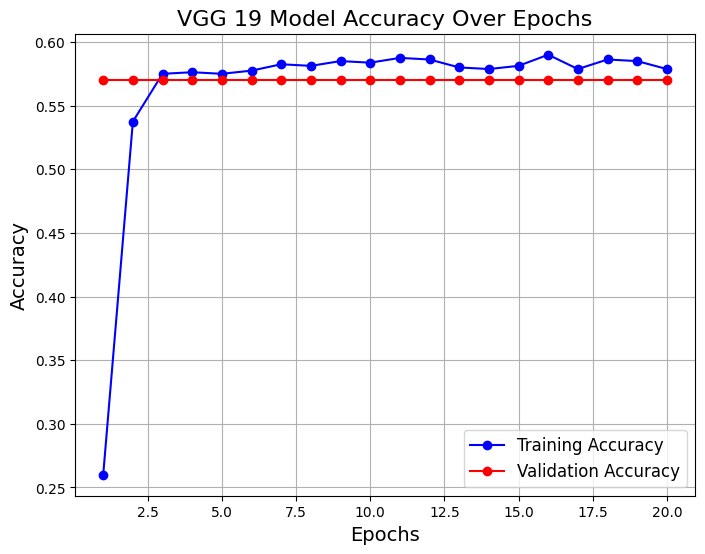

In [ ]:

# Extract accuracy and validation accuracy
accuracy = history1_dict['accuracy']
val_accuracy = history1_dict['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-o', label='Validation Accuracy')
plt.title('VGG 19 Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


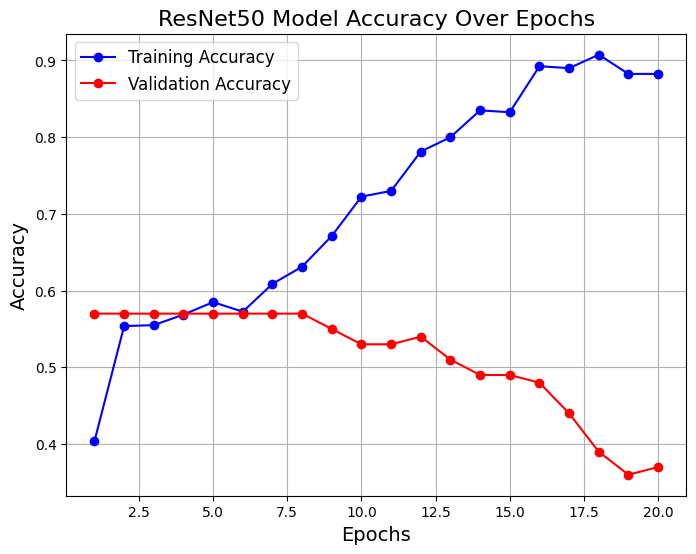

In [ ]:

# Extract accuracy and validation accuracy
accuracy = history2_dict['accuracy']
val_accuracy = history2_dict['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-o', label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


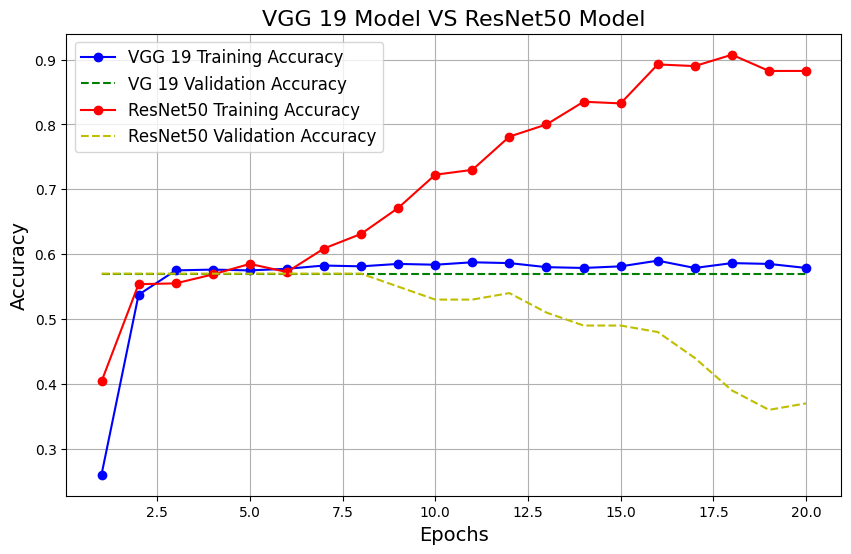

In [ ]:
accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']

accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

epochs = range(1, len(accuracy1) + 1)

# Plot training accuracy for both models
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy1, 'b-o', label='VGG 19 Training Accuracy')
plt.plot(epochs, val_accuracy1, 'g--', label='VG 19 Validation Accuracy')
plt.plot(epochs, accuracy2, 'r-o', label='ResNet50 Training Accuracy')
plt.plot(epochs, val_accuracy2, 'y--', label='ResNet50 Validation Accuracy')

# Add labels, title, and legend
plt.title('VGG 19 Model VS ResNet50 Model', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Degree Centrality: {1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2, 5: 0.2, 6: 0.2}


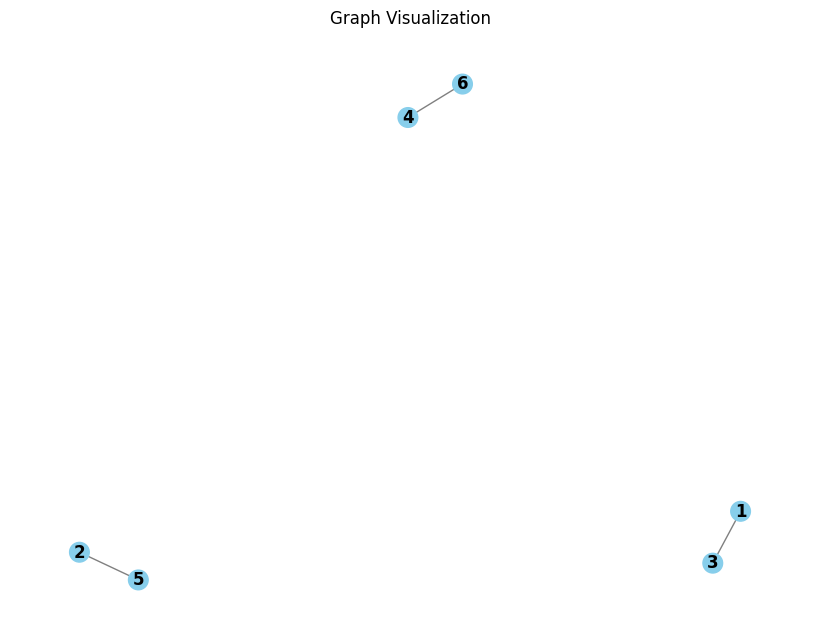

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph instance
graph = nx.Graph()

# Example: Add nodes for images (replace with your actual data)
images = list(range(1, 7))  # Assuming 6 images, replace with your actual image identifiers
graph.add_nodes_from(images)

# Example: Add edges based on relationships (replace with your logic)
# For instance, connect images of the same class
# Replace `image_classes` with the actual class labels for your images
image_classes = {1: 'A', 2: 'B', 3: 'A', 4: 'C', 5: 'B', 6: 'C'}
edges = [
    (i, j) for i in images for j in images
    if i != j and image_classes[i] == image_classes[j]
]
graph.add_edges_from(edges)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree Centrality:", degree_centrality)

# Draw the graph with labels and centrality-based node size
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(graph)  # Layout for graph visualization
nx.draw(
    graph, pos, with_labels=True, node_color='skyblue', edge_color='gray',
    node_size=[1000 * v for v in degree_centrality.values()], font_weight='bold'
)
plt.title("Graph Visualization")
plt.show()
